In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm
from simulation.cl_simulation import ComplexLangevinSimulation
from simulation.gpu_handler import GPU_handler
from src.numba_target import use_cuda

def run_simulation(config, n_steps = int(1e4)):
    # define simulation parameters

    sim = ComplexLangevinSimulation(config)
    if use_cuda: 
        gpu_handler = GPU_handler(sim)
        gpu_handler.to_device()

    # register observable
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True)

    # start the loop 
    for _ in tqdm(range(n_steps)):
        sim.step()
        sim.compute('1_moment')

    sim.finish()
    if use_cuda: gpu_handler.to_host()

    return sim

Using Numba
Using double precision
Using C^1


In [3]:
errors = []
cl_estimate = []
angles = []
num = 16
angles = np.arange(num)/num*2*np.pi

sigma_abs = 4
sigma_vals_cl = sigma_abs*(np.cos(angles) + 1j*np.sin(angles))

ineraction = 2


In [4]:
import numpy as np
from simulation.config import Config

data = []

for idx, (angle, sigma) in enumerate(zip(angles, tqdm(sigma_vals_cl))):
    config = Config(dt = 5e-2, trajs = int(1e5), dims = [1], mass_real = sigma, interaction = 2, ada_step = True)
    sim = ComplexLangevinSimulation(config)
    
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True, thermal_time=3, auto_corr=0.1)

    for _ in (range(int(1e3))):
        sim.step()
        for name, tr in sim.trackers.items():
            tr.mark_equilibrated_trajs()
            tr.compute()
    sim.finish()


    data.append(sim.trackers['1_moment'].history.flatten())


  0%|          | 0/16 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
 94%|█████████▍| 15/16 [00:28<00:01,  1.91s/it]


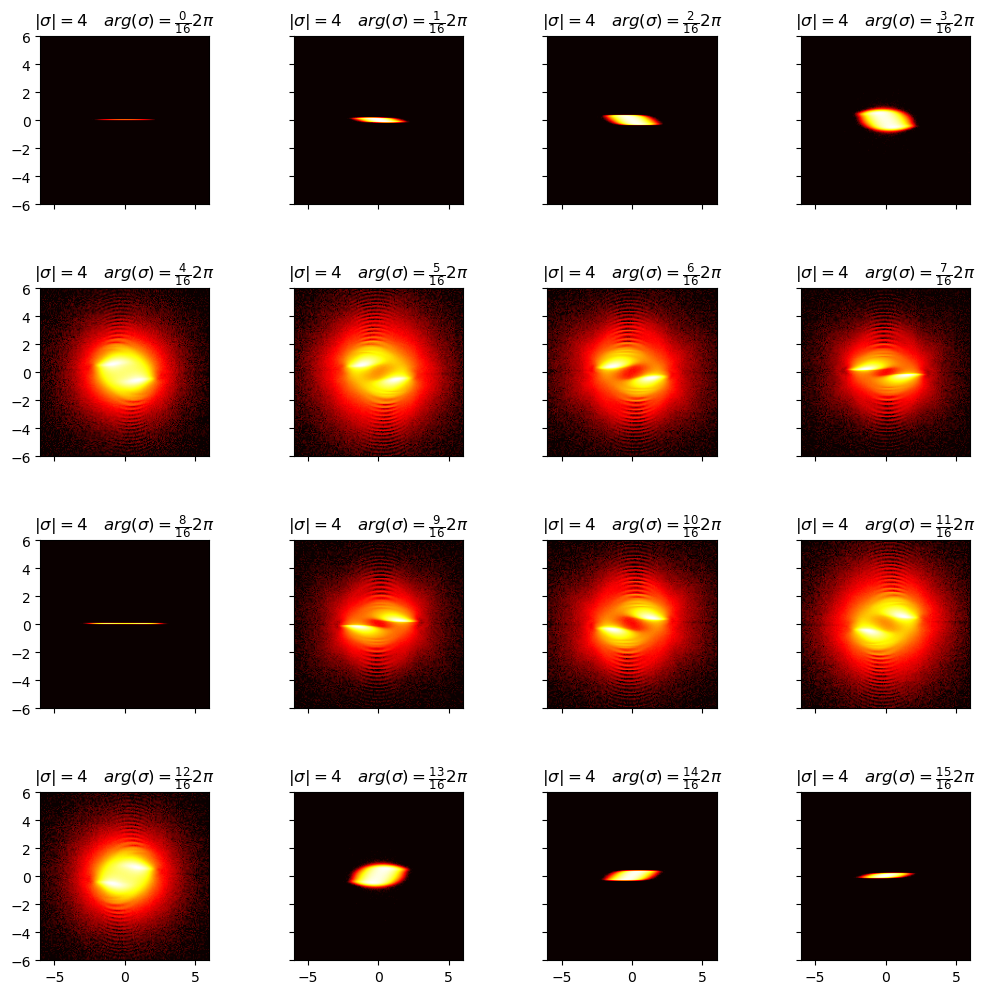

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

for idx, da in enumerate(data):
    
    magnitudes = np.abs(da)
    da = da[magnitudes <= 20]   
    art_dp = 10+10j
    da = np.append([art_dp, -art_dp], da)
    real_parts, imag_parts = da.real, da.imag
    bins = 500
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    ax = axes[idx]
    # Plot the heatmap
    ax.imshow(
        np.log10(heatmap+1).T,
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='hot',
        aspect='auto',
    )
    label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"

    ax.set_title(label)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
plt.show()